Idea: in order to do longitudinal analysis using our models, we would like them to be well calibrated. Since models are trained on a non-random sample of comments, we should not expect them to be well calibrated to the natural distribution of comments. Furthermore, architectures besides LR are not even well calibrated to their training distribution.

To evaluate our calibration procedure, we see if the calibrated model can be used to infer the rate of attacks in an annotated test set. We also inspect calibration plots and the brier score.

In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from serialization import load_pipeline
from baselines import load_comments_and_labels, assemble_data
from sklearn.metrics import roc_curve, brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# load data
task = 'attack'
data = load_comments_and_labels(task)

In [85]:
#load model trained on train split
model_name = 'linear_char_ed_train'
model_type = 'linear_char_ed'
path = '../../models/%s/%s' % (task, model_type)
model =  load_pipeline(path, model_name)

In [86]:
# train calibrator on dev set, eval done on test
# all data comes from data sampled at random

from sklearn.linear_model import LogisticRegression as LR
from sklearn.isotonic import IsotonicRegression as IR

X_dev, y_dev = assemble_data(data, 'comments', 'plurality', splits = ['dev'], samples = ['random'])
X_test, y_test = assemble_data(data, 'comments', 'plurality', splits = ['test'], samples = ['random'])

y_dev_pred = model.predict_proba(X_dev)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

In [87]:
_, y_all = assemble_data(data, 'comments', 'plurality', samples = ['random'])
print(y_all.shape)
y_all.mean()

(37634,)


0.0091672423872030603

In [88]:
lr_calibrator = LR().fit( y_dev_pred.reshape( -1, 1 ), y_dev )                                                       
ir_calibrator = IR( out_of_bounds = 'clip' ).fit( y_dev_pred, y_dev )

In [89]:
y_test_pred_lr_calibrated = lr_calibrator.predict_proba( y_test_pred.reshape( -1, 1 ))[:,1]
y_test_pred_ir_calibrated = ir_calibrator.transform( y_test_pred ) 

In [90]:
# plot calibration transformations 

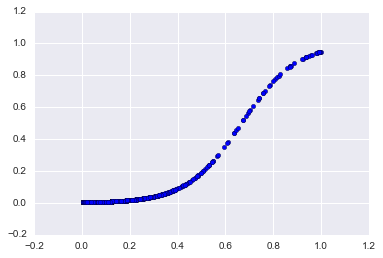

In [91]:
plt.scatter(y_test_pred, y_test_pred_lr_calibrated)

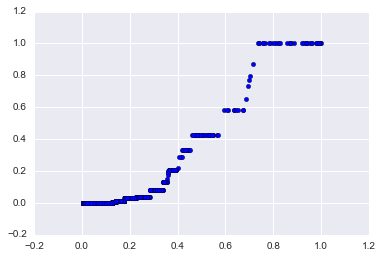

In [92]:
plt.scatter(y_test_pred, y_test_pred_ir_calibrated)

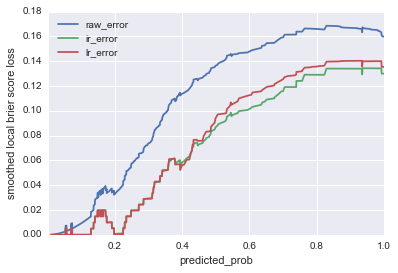

In [93]:
df_brier = pd.DataFrame()
df_brier['predicted_prob'] = y_test_pred
df_brier['raw_error'] = (y_test - y_test_pred)**2
df_brier['ir_error'] = (y_test - y_test_pred_ir_calibrated)**2
df_brier['lr_error'] = (y_test - y_test_pred_lr_calibrated)**2
df_brier = df_brier.sort_values('predicted_prob')
df_brier.index = df_brier['predicted_prob']
df_brier = pd.rolling_mean(df_brier[['raw_error', 'ir_error', 'lr_error']], 200)
df_brier.plot()
plt.ylabel('smoothed local brier score loss')

In [94]:
# see how well model scores can be used to infer attack rates for each calibrator

def plot_attack_rates(y, y_pred):
    
    print('brier_score_loss: ',  brier_score_loss(y, y_pred))
    print('log_loss: ',  log_loss(y, y_pred))
    print('roc_auc_score: ',  roc_auc_score(y, y_pred))
        
    true_rate = y.mean()
    expected_rate = y_pred.mean()
    print('true_rate: ', true_rate, ' expected_rate: ', expected_rate)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    rates = [true_rate * tpr[i] + (1-true_rate) * fpr[i] for i in range(len(thresholds))]
    
    plt.plot(thresholds, rates, label='threshold rate')
    plt.plot(thresholds, [true_rate] * len(rates), label='true rate')
    plt.plot(thresholds, [expected_rate] * len(rates), label='expected rate')
    plt.ylabel('attack rate')
    plt.xlabel('threshold')
    plt.ylim((true_rate - 2.0*true_rate, true_rate + 2.0*true_rate))
    plt.legend()
    plt.xlim(0.0, 0.6)

brier_score_loss:  0.0104372378311
log_loss:  0.0749894085529
roc_auc_score:  0.981287335638
true_rate:  0.00948196114709  expected_rate:  0.0690152


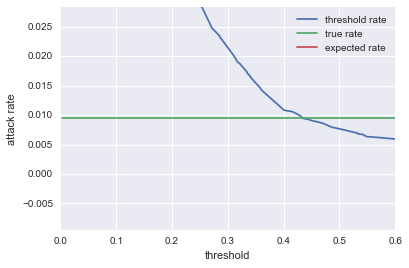

In [95]:
#no calibration
plot_attack_rates(y_test, y_test_pred)

brier_score_loss:  0.00471483816757
log_loss:  0.0368245004985
roc_auc_score:  0.978369532411
true_rate:  0.00948196114709  expected_rate:  0.0108583374526


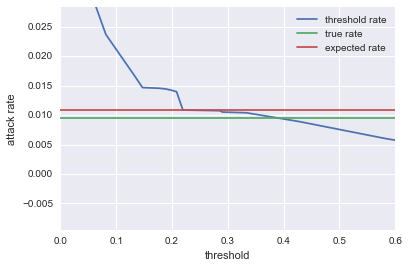

In [96]:
# isotonic regression calibration
plot_attack_rates(y_test, y_test_pred_ir_calibrated)

brier_score_loss:  0.00485288803301
log_loss:  0.0228516631178
roc_auc_score:  0.981287335638
true_rate:  0.00948196114709  expected_rate:  0.0115423619033


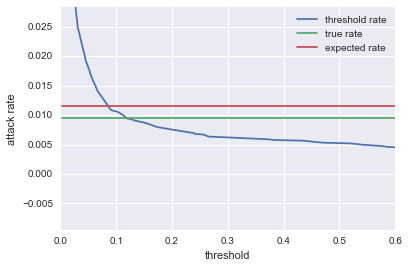

In [97]:
# logistic regression calibration
plot_attack_rates(y_test, y_test_pred_lr_calibrated)

### What about picking a threshold on the dev set?

In [98]:
true_rate = y_dev.mean()
thresholds = sorted(y_dev_pred)

In [99]:
rates = [(y_dev_pred > t).mean() for t in thresholds]

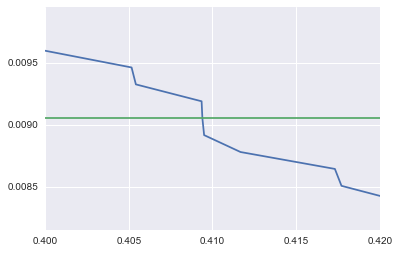

In [106]:
plt.plot(thresholds, rates)
plt.ylim((true_rate - 0.1*true_rate, true_rate + 0.1*true_rate))
plt.xlim((0.4, 0.42))

plt.plot(thresholds, [true_rate] * len(rates), label='true rate')

In [110]:
threshold = 0.408

In [111]:
y_test.mean()

0.0094819611470860314

In [112]:
(y_test_pred > threshold).mean()

0.010638297872340425

In [113]:
df_sub = pd.DataFrame()
df_sub['true'] = y_test
df_sub['threshold'] = (y_test_pred > threshold).astype(int)
df_sub['sum'] = y_test_pred_ir_calibrated

In [122]:
n = df_sub.shape[0]

In [123]:
ks = [1, 8, 64, int(n/64), int(n/8), n]

In [139]:
results_list=[]

for k in ks:
    for i in range(1000):
        idxs = np.random.choice(n, k)
        df_temp = df_sub.loc[idxs]
        result_dict = {
            'true': df_sub.loc[idxs]['true'].mean(),
            'sum': df_sub['sum'].loc[idxs].mean(),
            'threshold': df_sub['threshold'].loc[idxs].mean(),
            'k': k,
        }
        
        results_list.append(result_dict)
        
df_results = pd.DataFrame(results_list)

In [145]:
df_results = df_results*100

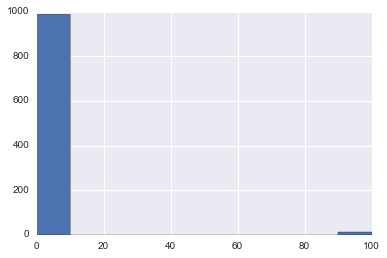

In [152]:
df_results.query('k==100')['true'].hist()

In [146]:
df_results.groupby(['k']).mean()

,i,sum,threshold,true
k,,,,
100,49950,1.051776,1.400000,1.200000
800,49950,1.218954,1.312500,1.025000
6400,49950,1.035721,0.993750,0.904687
13500,49950,1.029348,1.004444,0.915556
108100,49950,1.079032,1.059019,0.940241
864800,49950,1.087027,1.066883,0.950220


In [148]:
df_results.groupby(['k']).std()

,i,sum,threshold,true
k,,,,
100,28881.943598,6.309195,11.754921,10.893974
800,28881.943598,2.957041,3.993688,3.565401
6400,28881.943598,0.925781,1.214444,1.150642
13500,28881.943598,0.627675,0.849943,0.841187
108100,28881.943598,0.238482,0.312102,0.295317
864800,28881.943598,0.085324,0.111598,0.104222


In [153]:
from stats_utils import bayesian_rate_interval
num_attacks = df_sub['true'].sum()
num_comments = n
bayesian_rate_interval(num_attacks, num_comments, conf=95, plot =True)

(0.0076480128898662545, 0.011721217896266765)